In [137]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data Loading of Glitch Catalogue

Let us load the Glitch Catalogue from atnf into a clean Pandas Dataframe

In [138]:
import requests

url = "https://www.atnf.csiro.au/research/pulsar/psrcat/glitchTbl.html"
response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
with open('raw_page.html', 'w', encoding='utf-8') as f:
    f.write(response.text)


In [139]:
import pandas as pd
from bs4 import BeautifulSoup
import re

# Load the saved HTML file
with open('raw_page.html', 'r', encoding='utf-8') as f:
    html_content = f.read()

# Try multiple extraction methods
def extract_pulsar_data(html):
    # Method 1: Try pandas read_html
    try:
        tables = pd.read_html(html)
        if len(tables) > 0:
            return tables[0]  # Return first table found
    except:
        pass

    # Method 2: BeautifulSoup parsing
    soup = BeautifulSoup(html, 'html.parser')

    # Look for <pre> tags (common for fixed-width data)
    pre = soup.find('pre')
    if pre:
        lines = [line.strip() for line in pre.text.split('\n') if line.strip()]

        # Find header line
        header_line = next((i for i, line in enumerate(lines)
                          if 'PSRJ' in line and 'GLEP' in line), None)

        if header_line is not None:
            # Process data lines
            data = []
            for line in lines[header_line+1:]:
                # Clean and split line
                clean_line = re.sub(r'\s+', ' ', line).strip()
                if re.match(r'^(J|B)\d', clean_line):  # Matches pulsar names
                    data.append(clean_line.split(None, 7))  # Split into max 8 columns

            if data:
                headers = ['PSR', 'PSRJ', 'GLEP (MJD)', 'Δν/ν (10^9)',
                          'Δν/ν\' (10^3)', 'Q', 'T_d (d)', 'Reference']
                return pd.DataFrame(data, columns=headers)

    # Method 3: Direct regex parsing
    table_pattern = re.compile(
        r'(J\d{4}\+\d{4}|B\d{4}\+\d{2})\s+'    # PSR
        r'(J\d{4}\+\d{4}|B\d{4}\+\d{2})\s+'    # PSRJ
        r'(\d+\.\d+|\d+\(\d+\))\s+'            # GLEP
        r'([\d\.]+\(?\d*\)?)\s+'               # Δν/ν
        r'([\d\.\-]+\(?\d*\)?|-)\s+'           # Δν/ν'
        r'([\d\.]+\(?\d*\)?|-)\s+'             # Q
        r'([\d\.]+\(?\d*\)?|-)\s+'             # T_d
        r'(\w+)'                               # Reference
    )
    matches = table_pattern.findall(html)
    if matches:
        headers = ['PSR', 'PSRJ', 'GLEP (MJD)', 'Δν/ν (10^9)',
                  'Δν/ν\' (10^3)', 'Q', 'T_d (d)', 'Reference']
        return pd.DataFrame(matches, columns=headers)

    return None

# Extract data
df = extract_pulsar_data(html_content)

if df is not None:
    # Clean the data
    df = df.replace({'': pd.NA, '-': pd.NA, ' ': pd.NA})
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].str.strip()

    # Save to CSV
    df.to_csv('pulsar_glitches_final.csv', index=False)
    print(f"Successfully extracted {len(df)} records")
    print(df.head())
else:
    print("Could not extract table data. Please try manual extraction.")

Successfully extracted 645 records
            0           1           2            3                          4  \
0         PSR        PSRJ  GLEP (MJD)  Δν/ν (10-9)  Δν&middot/ν&middot (10-3)   
1  J0007+7303  J0007+7303   54952.652     553.7(6)                    0.97(6)   
2    B0144+59  J0147+5922   53682(15)     0.056(3)                   -0.21(5)   
3    B0154+61  J0157+6212    58283(3)       2.6(3)                       <NA>   
4  J0146+6145  J0146+6145  51141(248)     650(150)                      14(5)   

      5        6          7  
0     Q  T_d (d)  Reference  
1  <NA>     <NA>     awd+12  
2  <NA>     <NA>     ywml10  
3  <NA>     <NA>     bsa+22  
4  <NA>     <NA>      mks05  


In [140]:
df.head()

,0,1,2,3,4,5,6,7
0,PSR,PSRJ,GLEP (MJD),Δν/ν (10-9),Δν&middot/ν&middot (10-3),Q,T_d (d),Reference
1,J0007+7303,J0007+7303,54952.652,553.7(6),0.97(6),<NA>,<NA>,awd+12
2,B0144+59,J0147+5922,53682(15),0.056(3),-0.21(5),<NA>,<NA>,ywml10
3,B0154+61,J0157+6212,58283(3),2.6(3),<NA>,<NA>,<NA>,bsa+22
4,J0146+6145,J0146+6145,51141(248),650(150),14(5),<NA>,<NA>,mks05


Clean the Data

In [141]:
import pandas as pd
from io import StringIO
import re


# 1. Clean column headers
df.columns = ['PSR', 'PSRJ', 'GLEP_MJD', 'delta_nu_nu', 'delta_nudot_nudot',
              'Q', 'T_d_days', 'Reference']

# 2. Fix HTML entities in values
def clean_html_entities(text):
    if pd.isna(text):
        return text
    replacements = {
        '&middot': '',
        '&minus': '-',
        '&times': '×'
    }
    for k, v in replacements.items():
        text = str(text).replace(k, v)
    return text.strip()

df = df.applymap(clean_html_entities)

# 3. Standardize number formats (e.g., 553.7(6) → 553.7±0.6)
def clean_numbers(val):
    if pd.isna(val) or not re.match(r'.*[0-9]', str(val)):
        return val
    val = str(val).replace('(', '±').replace(')', '')
    return val

df['delta_nu_nu'] = df['delta_nu_nu'].apply(clean_numbers)
df['delta_nudot_nudot'] = df['delta_nudot_nudot'].apply(clean_numbers)

# 4. Handle missing values consistently
df.replace(['', '-', 'NA', 'NaN', 'nan'], pd.NA, inplace=True)

# 5. Save final CSV
df.to_csv('pulsar_glitches_clean.csv', index=False, encoding='utf-8-sig')

print("Final cleaned data sample:")
print(df.head())

Final cleaned data sample:
          PSR        PSRJ    GLEP_MJD delta_nu_nu delta_nudot_nudot     Q  \
0         PSR        PSRJ  GLEP (MJD)  Δν/ν ±10-9        Δν/ν ±10-3     Q   
1  J0007+7303  J0007+7303   54952.652     553.7±6            0.97±6  <NA>   
2    B0144+59  J0147+5922   53682(15)     0.056±3           -0.21±5  <NA>   
3    B0154+61  J0157+6212    58283(3)       2.6±3              <NA>  <NA>   
4  J0146+6145  J0146+6145  51141(248)     650±150              14±5  <NA>   

  T_d_days  Reference  
0  T_d (d)  Reference  
1     <NA>     awd+12  
2     <NA>     ywml10  
3     <NA>     bsa+22  
4     <NA>      mks05  


#Loading entire pulsar(Glitching + Non-Glitching) using PSRQPY

Now we want the entire pulsar catalogue loaded, in order for comparison with the glitching set.

In [142]:
!pip install psrqpy --quiet

In [143]:
import psrqpy

query = psrqpy.QueryATNF(params=[
    'PSRJ',     # Pulsar name
    'P0',       # Period [s]
    'P1',       # Period derivative
    'AGE',      # Characteristic age [yr]
    'BSURF',    # Surface magnetic field [G]
    'DM',       # Dispersion measure [pc/cm^3]
    'S400',     # Flux at 400 MHz
    'S1400',    # Flux at 1400 MHz
    'TYPE',     # Type (binary, millisecond, etc.)
     # --- Newly Added Physical Parameters ---
    'F0',       # Spin frequency [Hz]
    'F1',       # Spin frequency derivative
    'F2',       # Spin frequency second derivative
    'EDOT'      # Rotational energy loss rate [erg/s]
])
atnf_df = query.table.to_pandas()

# Save as csv
atnf_df.to_csv('atnf_full_catalogue.csv', index=False)
print(atnf_df.head())

   TYPE        PSRJ            F1  S1400_ERR          EDOT        F1_ERR  \
0    HE  J0002+6216 -4.483540e-13        NaN  1.534306e+35  5.000000e-18   
1   NaN  J0006+1834 -4.357078e-15        NaN  2.479440e+32  2.493321e-17   
2  NRAD  J0007+7303 -3.612000e-12        NaN  4.514345e+35  5.000000e-16   
3   NaN    J0011+08           NaN        NaN           NaN           NaN   
4  RRAT  J0012+5431 -1.400000e-17        NaN  1.826919e+29           NaN   

         F0_ERR        F2_ERR        P1_ERR         BSURF  ...        F0  \
0  1.000000e-10           NaN  6.654376e-20  8.395828e+11  ...  8.668248   
1  2.908874e-10           NaN  1.200000e-17  1.220534e+12  ...  1.441446   
2  3.000000e-09  7.000000e-24  4.988794e-17  1.079675e+13  ...  3.165827   
3           NaN           NaN           NaN           NaN  ...  0.391716   
4  2.000000e-11           NaN           NaN  6.300381e+11  ...  0.330546   

         P0        P0_ERR  DM_ERR  S400           AGE            P1     DM  \
0  0.115

# Initial Inspection

Initial Data Inspection

In [144]:
print(df.info())                    # Check dtypes and missing values
print(df.describe(include='all'))   # Stats for all columns


# Unique counts
print("\nUnique values per column:")
print(df.nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645 entries, 0 to 644
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   PSR                627 non-null    object
 1   PSRJ               627 non-null    object
 2   GLEP_MJD           627 non-null    object
 3   delta_nu_nu        627 non-null    object
 4   delta_nudot_nudot  555 non-null    object
 5   Q                  137 non-null    object
 6   T_d_days           140 non-null    object
 7   Reference          645 non-null    object
dtypes: object(8)
memory usage: 40.4+ KB
None
             PSR        PSRJ  GLEP_MJD delta_nu_nu delta_nudot_nudot  \
count        627         627       627         627               555   
unique       212         212       620         573               427   
top     B1737-30  J1740-3015  56975(8)       0.4±1               1±1   
freq          37          37         3           7                 8   

               Q T_

In [145]:
df = pd.read_csv('pulsar_glitches_clean.csv')

In [146]:
df.head()

,PSR,PSRJ,GLEP_MJD,delta_nu_nu,delta_nudot_nudot,Q,T_d_days,Reference
0,PSR,PSRJ,GLEP (MJD),Δν/ν ±10-9,Δν/ν ±10-3,Q,T_d (d),Reference
1,J0007+7303,J0007+7303,54952.652,553.7±6,0.97±6,NaN,NaN,awd+12
2,B0144+59,J0147+5922,53682(15),0.056±3,-0.21±5,NaN,NaN,ywml10
3,B0154+61,J0157+6212,58283(3),2.6±3,NaN,NaN,NaN,bsa+22
4,J0146+6145,J0146+6145,51141(248),650±150,14±5,NaN,NaN,mks05


Take only central values, excluding uncertainties

In [147]:
import re
import numpy as np


def extract_value(s):
    try:
      return float(re.split(r'[±\s]', s.strip())[0])
    except:
      return np.nan
df['delta_nu_nu_clean'] = df['delta_nu_nu'].apply(extract_value)

group by PSRJ and compute  
count --> total number of glitches  
mean --> mean glitch size  
std --> standard deviation of glitch sizes

In [148]:
grouped = df.groupby('PSRJ')['delta_nu_nu_clean'].agg([
    ('glitch_count', 'count'),
    ('mean_glitch_size', 'mean'),
    ('std_glitch_size', 'std')
]).reset_index()

print(grouped)


           PSRJ  glitch_count  mean_glitch_size  std_glitch_size
0    J0007+7303             1        553.700000              NaN
1    J0146+6145             3       2240.000000      1967.256974
2    J0147+5922             1          0.056000              NaN
3    J0157+6212             3          2.823333         0.512868
4    J0205+6449             9       1594.888889      1879.105003
..          ...           ...               ...              ...
207  J2301+5852             4       5122.500000      7721.642204
208  J2325+6316             1          0.210000              NaN
209  J2337+6151             1      20579.400000              NaN
210  J2346-0609             1          0.550000              NaN
211        PSRJ             0               NaN              NaN

[212 rows x 4 columns]


In [149]:
df = df[~df['delta_nu_nu_clean'].isna()]
df

,PSR,PSRJ,GLEP_MJD,delta_nu_nu,delta_nudot_nudot,Q,T_d_days,Reference,delta_nu_nu_clean
1,J0007+7303,J0007+7303,54952.652,553.7±6,0.97±6,NaN,NaN,awd+12,553.700
2,B0144+59,J0147+5922,53682(15),0.056±3,-0.21±5,NaN,NaN,ywml10,0.056
3,B0154+61,J0157+6212,58283(3),2.6±3,NaN,NaN,NaN,bsa+22,2.600
4,J0146+6145,J0146+6145,51141(248),650±150,14±5,NaN,NaN,mks05,650.000
5,J0146+6145,J0146+6145,53809.185840,1630±350,5100±1100,1.1(3),17.0(11),gdk11,1630.000
...,...,...,...,...,...,...,...,...,...
639,J2301+5852,J2301+5852,56035(2),-310±40,2700±200,NaN,NaN,akn+13,-310.000
640,J2301+5852,J2301+5852,56125(2),260±50,-2600±200,NaN,NaN,akn+13,260.000
641,B2323+63,J2325+6316,53957(31),0.21±2,-0.32±4,NaN,NaN,bsa+22,0.210
642,B2334+61,J2337+6151,53615(6),20579.4±12,156±4,0.0046(7),21.4(5),ymw+10,20579.400


# Glitchers vs Non-Glitchers

Create glitcher/ Non-glitcher Labels

From the first dataset containing only glitching pulsars,we'll mark those as glitchers(label = 1) and others as non-glitchers(label = 0 )

In [150]:
# Get a list of glitching PSRJ names
glitching_psrs = df['PSRJ'].dropna().unique()

# Create binary label in ATNF DataFrame
atnf_df['is_glitcher'] = atnf_df['PSRJ'].isin(glitching_psrs).astype(int)
atnf_df['is_glitcher']

,is_glitcher
0,0
1,0
2,1
3,0
4,0
...,...
4298,0
4299,0
4300,0
4301,0


# Exploratory Data Analysis

Histogram of Age

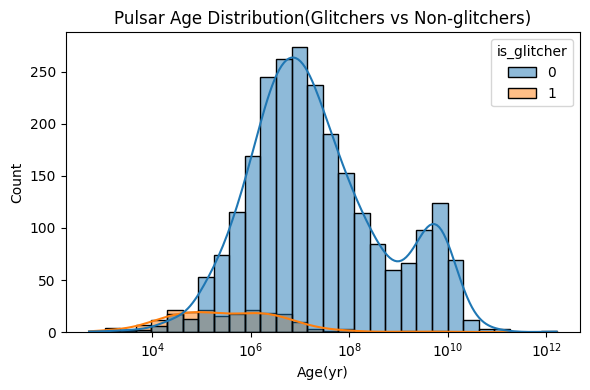

In [151]:
filtered = atnf_df[['AGE','BSURF','DM','is_glitcher']].dropna()

# Histogram of age
plt.figure(figsize =(6,4))
#plt.legend(title='Glitcher')
sns.histplot(data=filtered, x = 'AGE',hue = 'is_glitcher',log_scale=True,bins = 30,kde=True)
plt.title('Pulsar Age Distribution(Glitchers vs Non-glitchers)')
plt.xlabel('Age(yr)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


Surface Magnetic field vs Age

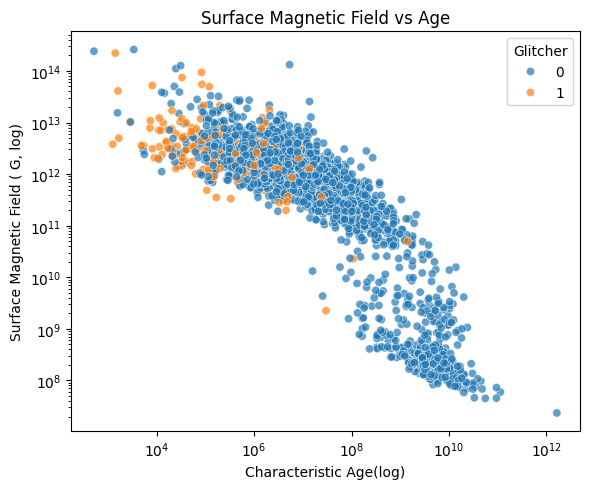

In [152]:
plt.figure(figsize=(6,5))
sns.scatterplot(data=filtered,x='AGE',y='BSURF',hue='is_glitcher',alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.title('Surface Magnetic Field vs Age')
plt.xlabel('Characteristic Age(log)')
plt.ylabel('Surface Magnetic Field ( G, log)')
plt.legend(title='Glitcher')
plt.tight_layout()
plt.show()

To check correlations and separability between features for glitchers/non glitchers- Pairplot of key features

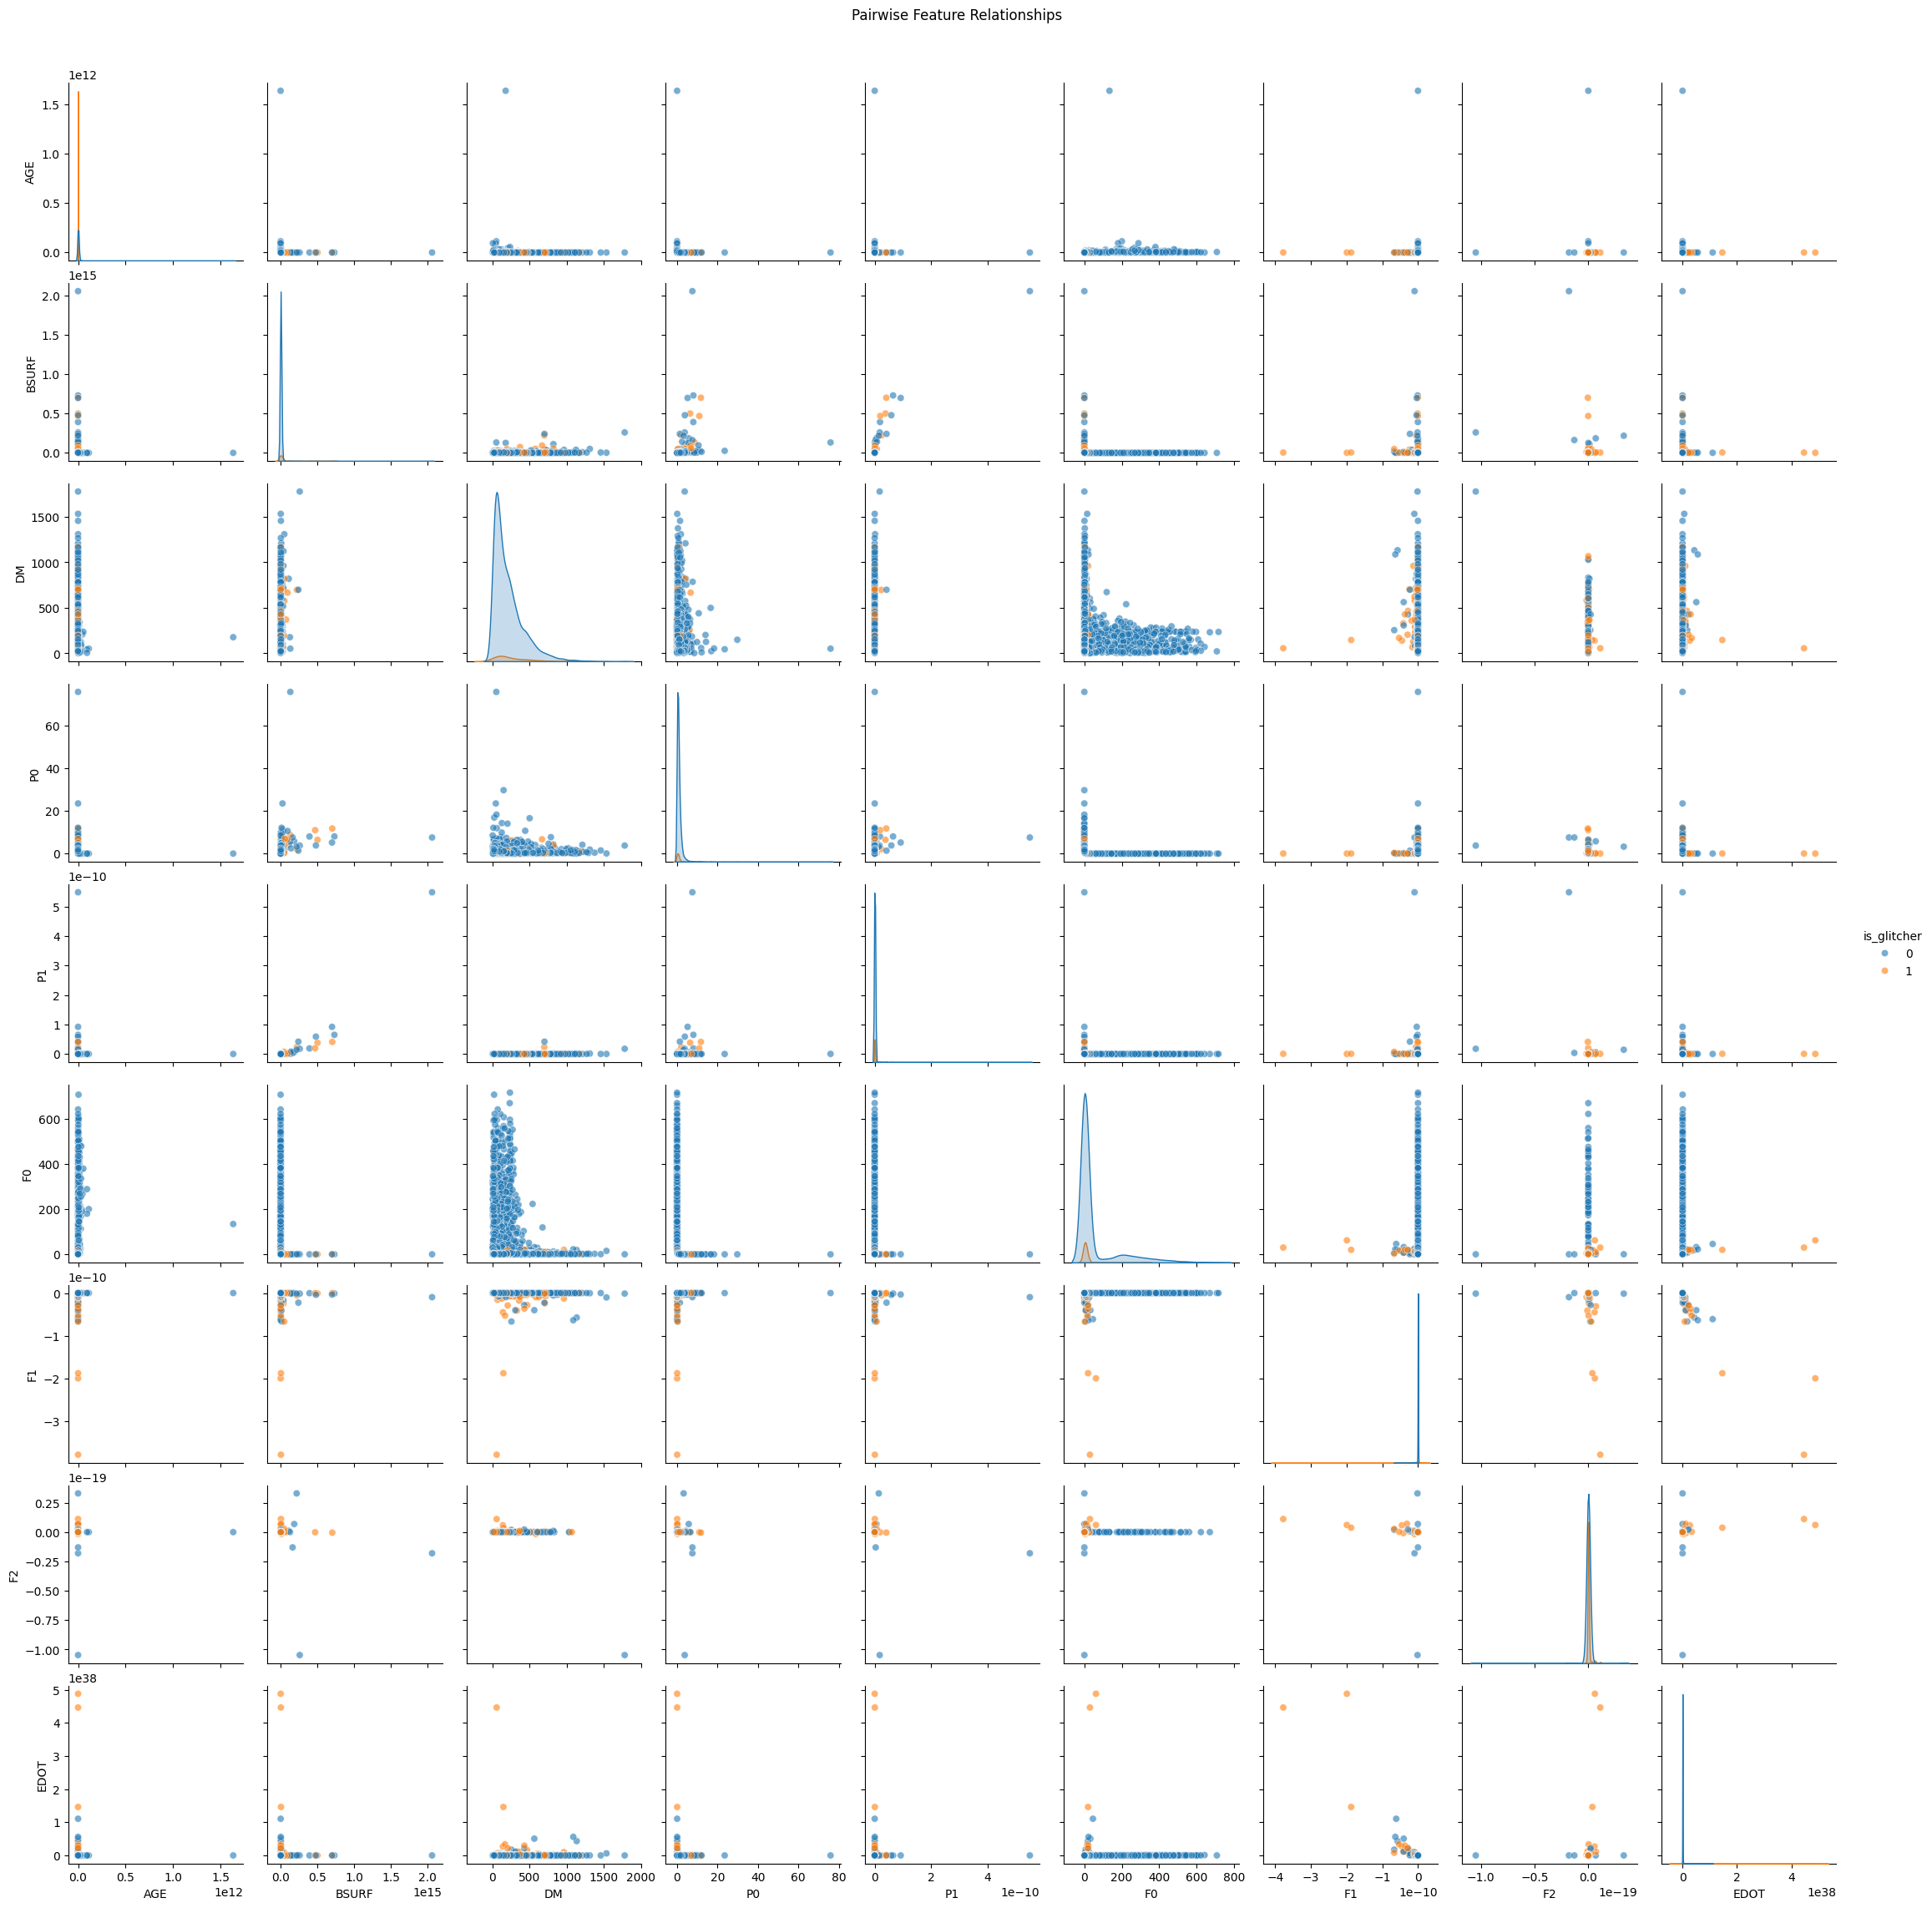

In [153]:
sns.pairplot(atnf_df[['AGE', 'BSURF', 'DM', 'P0', 'P1','F0','F1','F2','EDOT', 'is_glitcher']],hue =  'is_glitcher', plot_kws={'alpha': 0.6})
plt.suptitle("Pairwise Feature Relationships", y=1.02)
plt.show()

Correlation Heatmap(within glitchers vs non-glitchers)

Are certain pulsar types(e.g., RRAT, NRAD,HE,etc.) more likely to glitch ?

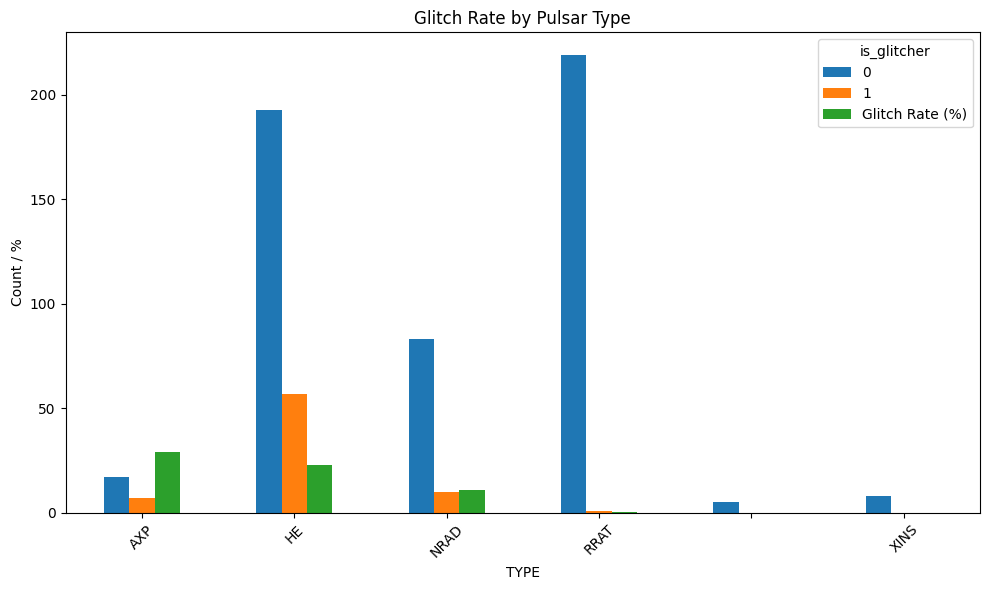

In [154]:
type_counts = atnf_df.groupby(['TYPE','is_glitcher']).size().unstack(fill_value=0)
type_counts['Glitch Rate (%)'] = 100 *type_counts[1]/(type_counts[0] +type_counts[1])

type_counts.sort_values('Glitch Rate (%)',ascending = False).plot(kind = 'bar',figsize = (10,6))
plt.title('Glitch Rate by Pulsar Type')
plt.ylabel('Count / %')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

From above,it can be seen that the type with highest glitch rate is the AXP , or Anomalous X-ray Pulsars, followed by HE or High energy pulsars

# Classification

Feature Selection and Preprocessing :

First, we select the most informative features( have included all features for example) based on our EDA and prepare the data for modeling. This involves handling missing values, scaling the features to a standard range, and performing a stratified split to ensure both training and test sets have a representative class distribution.

In [155]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

#Choose informative features ( based on EDA)
features = ['AGE','BSURF','DM','P0','P1','F0','F1','F2','EDOT']
X_raw = atnf_df[features]

# --- 2. Impute Missing Values ---
# Create an imputer object that will fill NaNs with the median of each column
imputer = SimpleImputer(strategy='median')

# Fit the imputer on the data and transform it
# The result is a NumPy array, so we'll put it back into a DataFrame
X_imputed = imputer.fit_transform(X_raw)
X = pd.DataFrame(X_imputed, columns=features, index=X_raw.index) # Recreate the DataFrame


# --- 3. Continue with your original workflow ---
# Get the target variable y, ensuring it's aligned with the imputed features X
y = atnf_df.loc[X.index, 'is_glitcher']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/Test/Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)

#Bringing in NNs with Pytorch

This is a preliminary experimental two hidden layer model, and more rigorous hyperparameter tuning could lead to a better result

An important step is to convert our arrays to the data structure familiar to PyTorch - tensors

In [156]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

#### Converting train/test numpy arrays to PyTorch Tensors
# Ensure the data is in NumPy array format before converting to tensor
X_train_tensor = torch.from_numpy(X_train).float() # Convert to float for compatibility with neural network layers
y_train_tensor = torch.from_numpy(y_train.values).float().unsqueeze(1) # Convert to float and add a dimension

X_test_tensor = torch.from_numpy(X_test).float() # Convert to float
y_test_tensor = torch.from_numpy(y_test.values).float().unsqueeze(1) # Convert to float and add a dimension

print("Tensors created:")
print(f"X_train_tensor shape: {X_train_tensor.shape}")
print(f"y_train_tensor shape: {y_train_tensor.shape}")
print(f"X_test_tensor shape: {X_test_tensor.shape}")
print(f"y_test_tensor shape: {y_test_tensor.shape}")

Tensors created:
X_train_tensor shape: torch.Size([3442, 9])
y_train_tensor shape: torch.Size([3442, 1])
X_test_tensor shape: torch.Size([861, 9])
y_test_tensor shape: torch.Size([861, 1])


We define our network. We will create a class that will inherit from Pytorch's nn.module.
We shall create a network with an input layer, two hidden layers with ReLU activation, and a final output layer

In [205]:
# --- Define the Model Architecture ---
class SimpleClassifier(nn.Module):
    def __init__(self, num_features):
        super(SimpleClassifier, self).__init__() # Call the constructor of the parent class

        # Define the layers of the network
        self.layer_1 = nn.Linear(num_features, 64) # Input layer to first hidden layer
        self.layer_2 = nn.Linear(64, 32)           # Second hidden layer
        self.output_layer = nn.Linear(32, 1)       # Output layer

        # Define the activation function
        self.relu = nn.ReLU()
        # Define a Dropout Layer. p = 0.5 means 50% of neurons will be dropped out
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # This function defines the forward pass of the network
        # It specifies how data flows through the layers
        x = self.relu(self.layer_1(x))
        x = self.dropout(x) # Apply dropout after the first activation
        x = self.relu(self.layer_2(x))
        x = self.dropout(x) # Apply dropout after the first activation
        x = self.output_layer(x)
        return x

Now, we create an instance of our model. Most importantly, we'll set up the loss function, BCEWithLogitsLoss. This loss is perfect for binary classification and allows us to easily handle class imbalance by calculating a pos_weight.

In [206]:
# --- Initialize the Model ---
num_features = X_train.shape[1]
model = SimpleClassifier(num_features)
print(model)

# --- Handle Class Imbalance ---
# Calculate the weight for the positive class (glitchers)
# This is the ratio of non-glitchers to glitchers
num_negatives = np.sum(y_train == 0)
num_positives = np.sum(y_train == 1)
#original weight
pos_weight_value = num_negatives / num_positives
pos_weight = torch.tensor([pos_weight_value])
# using a less aggressive weight
# dampened_weight_value = np.sqrt(pos_weight_value)
# pos_weight = torch.tensor([dampened_weight_value])


# --- Define Loss Function and Optimizer ---
# BCEWithLogitsLoss is numerically stable and combines a Sigmoid layer and the BCELoss
# We pass `pos_weight` to it to penalize errors on the rare positive class more heavily
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Adam is a popular and effective optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

SimpleClassifier(
  (layer_1): Linear(in_features=9, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=32, bias=True)
  (output_layer): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)


The Training Loop
This is where the model learns. We loop through the data for a set number of epochs, performing the forward pass, calculating the loss, performing the backward pass (backpropagation), and updating the model's weights.

In [207]:
# --- Training the Model ---
epochs = 1000
batch_size = 128

for epoch in range(epochs):
    # Set the model to training mode
    model.train()

    # Simple batching for demonstration
    for i in range(0, len(X_train_tensor), batch_size):
        # Get a batch of data
        X_batch = X_train_tensor[i:i+batch_size]
        y_batch = y_train_tensor[i:i+batch_size]

        # 1. Forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(X_batch)

        # 2. Calculate the loss
        loss = criterion(outputs, y_batch)

        # 3. Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.zero_grad() # Clear previous gradients
        loss.backward()

        # 4. Perform a single optimization step (parameter update)
        optimizer.step()

    # Print progress
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [100/1000], Loss: 0.8492
Epoch [200/1000], Loss: 0.6669
Epoch [300/1000], Loss: 0.6391
Epoch [400/1000], Loss: 0.5530
Epoch [500/1000], Loss: 0.5358
Epoch [600/1000], Loss: 0.5417
Epoch [700/1000], Loss: 0.5628
Epoch [800/1000], Loss: 0.5047
Epoch [900/1000], Loss: 0.5099
Epoch [1000/1000], Loss: 0.4760


Evaluation
Finally, we evaluate our trained model on the unseen test data. We set the model to evaluation mode.

In [208]:
# --- Evaluate the Model ---

# Set the model to evaluation mode (disables dropout, etc.)
model.eval()

# We don't need to compute gradients during evaluation
with torch.no_grad():
    # Get the raw model outputs (logits)
    y_logits = model(X_test_tensor)

    # Convert logits to probabilities using the sigmoid function
    y_probs = torch.sigmoid(y_logits)

    # Convert probabilities to binary predictions (0 or 1) using a 0.5 threshold
    y_pred = (y_probs > 0.5).int()

# Convert predictions back to a NumPy array to use scikit-learn metrics
y_pred_numpy = y_pred.numpy()

# --- Print Evaluation Metrics ---
print("\n--- PyTorch NN Results ---")
print(classification_report(y_test, y_pred_numpy))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_numpy))


--- PyTorch NN Results ---
              precision    recall  f1-score   support

           0       0.99      0.85      0.92       819
           1       0.21      0.76      0.33        42

    accuracy                           0.85       861
   macro avg       0.60      0.81      0.62       861
weighted avg       0.95      0.85      0.89       861

Confusion Matrix:
 [[700 119]
 [ 10  32]]
